![Image of cyclegan](https://raw.githubusercontent.com/eriklindernoren/PyTorch-GAN/master/assets/cyclegan.png)

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Style transfer using GAN

**One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.**


**However, in practice, pathologists rarely have access to both types of MRI images for review and diagnosis purposes. This is because of a variety of reasons such as certain scan time limitations as well as other factors such as distorted contrast found in MRI images due to noise or artifacts.**

In [2]:
#Import all the required libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Data understanding

In [3]:
# paths of T1 and T2 images

T1_path = '/gdrive/MyDrive/capstone/dataset/Tr1'
T2_path = '/gdrive/MyDrive/capstone/dataset/Tr2'

## Reading & Reszing Images 

In [4]:
# resizing to 256 x 256
tr1 = tf.keras.preprocessing.image_dataset_from_directory(T1_path,
                                                          color_mode='grayscale',
                                                          batch_size=1,
                                                          label_mode=None,
                                                          image_size=(256,256),
                                                          shuffle=True,
                                                          seed=42,
                                                          interpolation='nearest')

Found 43 files belonging to 1 classes.


In [5]:
# resizing to 256 x 256
tr2 = tf.keras.preprocessing.image_dataset_from_directory(T2_path,
                                                          color_mode='grayscale',
                                                          batch_size=1,
                                                          label_mode=None,
                                                          image_size=(256,256),
                                                          shuffle=True,
                                                          seed=42,
                                                          interpolation='nearest')

Found 46 files belonging to 1 classes.


## Image Processing 

In [6]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) /127.5
    return image

In [7]:
# Applying the function to both the datasets
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [8]:
# process both classes of MRI images
AUTOTUNE = tf.data.experimental.AUTOTUNE  # to use parallel processing of cpu

tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()

tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache()

In [9]:
# generating next samples
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

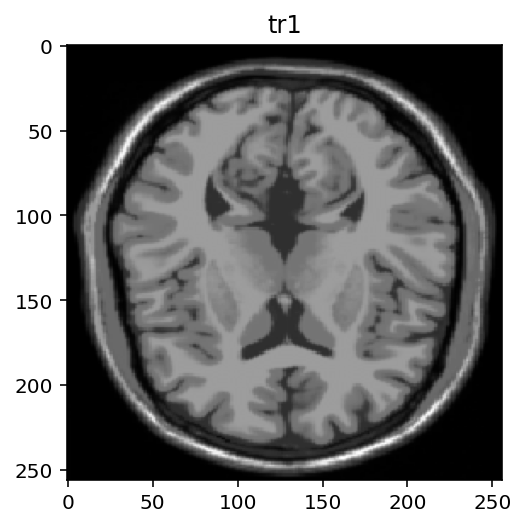

In [10]:
# plottin Tr1
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

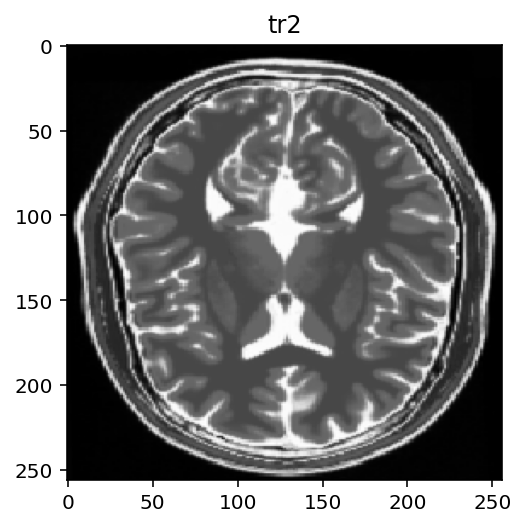

In [11]:
# plotting Tr2
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

**There are two main types of MRI images, T1-weighted MRI and T2-weighted MRI images. Both types of MRI contrast different regions within the body.**

- **T1-weighted → fat issue appear to be bright**
- **T2-weighted → both fat and water regions appear to be bright**

# Model Building & Training

### Hyper-Parameters

In [12]:
drop_out = 0.5  
LAMBDA = 1                     # weight of cyclic and identity loss
LAMBDA_adversarial = 0.5       # weight of discriminator loss
learning_rate_G = 2e-4
learning_rate_D = 2e-4
beta_1 = 0.5
beta_2 = 0.999
EPOCHS = 200

- **LAMBDA is deciding the weights of Cycle consistency loss and Identity loss, after experiminting with different values, 1 was giving better results.**

- **Adam optimizer is used here with small learning rate, and further decaying the learning rate for smooth training.**

- **LAMBDA_adversarial decides weightage of discriminator loss, 0.5 giving good results.**

### Instance Normalization & network building blocks

In [13]:
# creatig class of instance normalization

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

    
# writing a downsample block

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

# writing a up sample block

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(drop_out))
    result.add(tf.keras.layers.ReLU())
    return result

### Generator U-net Architecture Building

In [14]:
# function to create U-net generator

def unet_generator():
    down_stack = [
                  downsample(64,4, False), #(bs,128,128,64)
                  downsample(128,4,), #(bs,64,64,128)
                  downsample(256,4), #(bs,32,32,256)
                  downsample(512,4), #(bs,16,16,512)
                  downsample(512,4), #(bs,8,8,512)
                  downsample(512,4), #(bs,4,4,512)
                  downsample(512,4), #(bs,2,2,512)
                  downsample(512,4) #(bs,1,1,512)
                 ]
    
    up_stack = [
                upsample(512, 4, True), #(bs, 2,2,1024)
                upsample(512, 4, True), #(bs, 4,4,1024)
                upsample(512, 4, True), #(bs, 8,8,1024)
                upsample(512, 4), #(bs, 16,16,1024)
                upsample(256, 4), #(bs, 32,32,512)
                upsample(128, 4), #(bs, 64,64,256)
                upsample(64, 4) #(bs, 128,128,128)
               ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

- **U-net consists of a contracting path and an expansive path, similar to encoder,decoder architecture.**
- **keeping the size of output image to 256 x 256, same as the size of input image domain.**

In [15]:
# initializing the generator
generator_g = unet_generator()
generator_f = unet_generator()

### Discriminator Building

In [16]:
# function for discriminator
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    #x = inp
    down1 = downsample(64,4,False)(inp) #(bs, 128,128,64)
    down2 = downsample(128,4)(down1) #(bs,64,64,128)
    down3 = downsample(256,4)(down2) #(bs,32,32,256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs = inp, outputs=last)

In [17]:
# initializing the discriminator

discriminator_x = discriminator()
discriminator_y = discriminator()

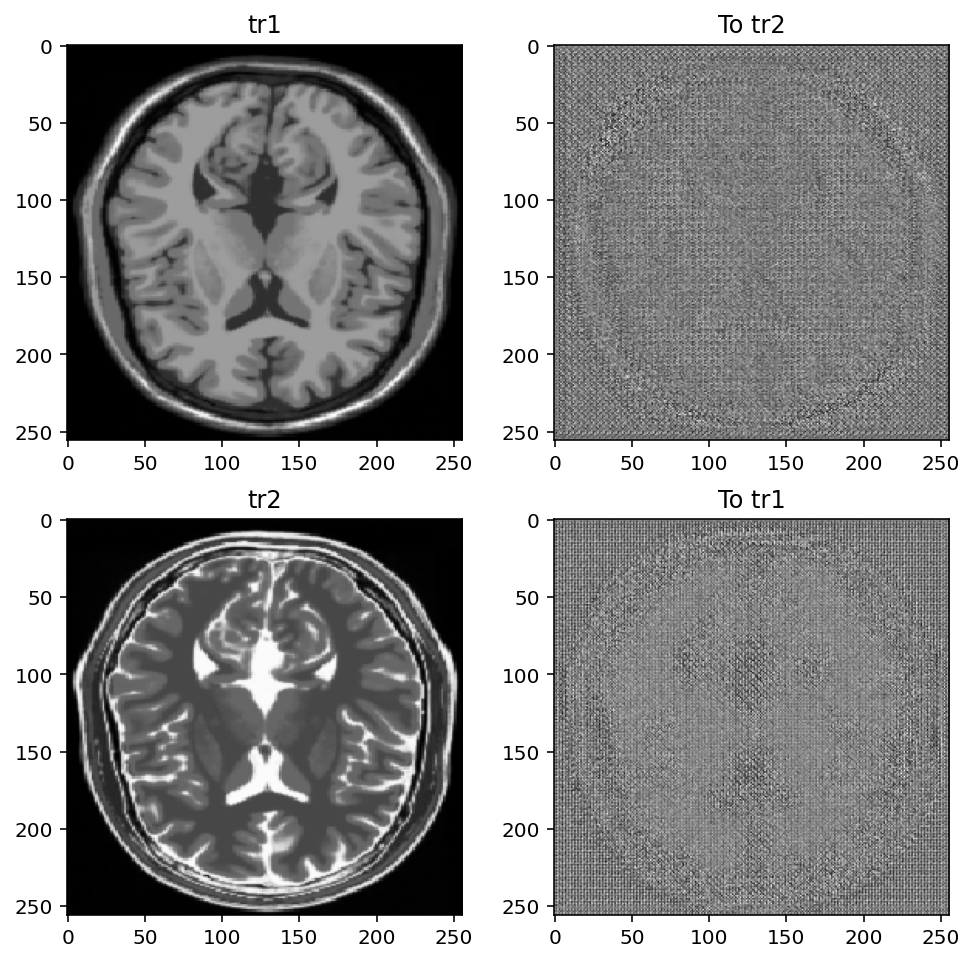

In [18]:
# checking if generator is working or not
# just randomly passing sample images to generator

to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

### Defining Loss Funsctions

In [19]:
# defining a binary cross entropy loss function
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# discriminator adverserial loss
def discriminator_loss(real, generated):
  
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * LAMBDA_adversarial

In [21]:
# generator adverserial loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [22]:
# defining a cyclic loss of a generator
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [23]:
# identity loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

**Adversarial loss :** Both generators are attempting to “fool” their corresponding discriminator into being less able to distinguish their generated images from the real versions.

However, the adversarial loss alone is not sufficient to produce good images, as it leaves the model under-constrained.It enforces that the generated output be of the appropriate domain, but does not enforce that the input and output are recognizably the same.

**Cycle consistency loss :** It relies on the expectation that if you convert an image to the other domain and back again, by successively feeding it through both generators, you should get back something similar to what you put in.

**Identity loss :** It enforce that CycleGAN preserves the overall color structure of the picture. It introduce a regularization term that helps to keep the tint of the picture consistent with the original image.



### Defining Optimizer

In [24]:
# exponentially decaying the learning rate after each epoch for smooth learning
# on both generator and discriminator side

#lr_schedule_G = tf.keras.optimizers.schedules.ExponentialDecay(
#    learning_rate_G,
#    decay_steps=100000,
#    decay_rate=0.95,
#    staircase=True)

#lr_schedule_D = tf.keras.optimizers.schedules.ExponentialDecay(
#    learning_rate_D,
#    decay_steps=100000,
#    decay_rate=0.95,
#    staircase=True)

# initializing the adam optimizer for both generator and discriminator

generator_g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_G, beta_1=beta_1, beta_2=beta_2)
generator_f_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_G, beta_1=beta_1, beta_2=beta_2)

discriminator_x_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_D, beta_1=beta_1, beta_2=beta_2)
discriminator_y_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_D, beta_1=beta_1, beta_2=beta_2)

### Checkpoints

In [25]:
# keeping the checkpoint for efficient training process 

checkpoint_path = "/gdrive/MyDrive/capstone/Models"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1,step_counter=50)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [26]:
# plotting function for generated images

def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

### Training Step Function

In [27]:
# training function

@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
        
        
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    return {'total_gen_g_loss':total_gen_g_loss,
            'total_gen_f_loss':total_gen_f_loss,
            'disc_x_loss':disc_x_loss,
            'disc_y_loss':disc_y_loss
           }

**we have in total 4 networks, two generator and two discriminator. At a time we are only training one network, keeping other networks in idle state.**

### Model Training

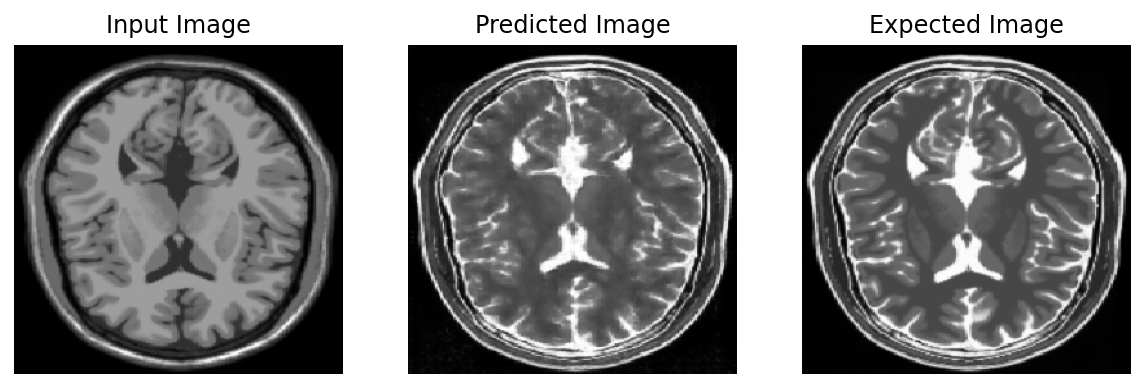

Average Generator loss G at epoch 200 : 0.819890022277832
Average Generator loss F at epoch 200 : 0.7751799821853638
Average Discriminator loss X at epoch 200 : 0.6961100101470947
Average Discriminator loss Y at epoch200 : 0.6785899996757507

time taken at epoch 200 is 33 sec



In [28]:
# traing the model

for epoch in range(EPOCHS):
    
    start = time.time()
    
    
    total_gen_g_loss=[]
    total_gen_f_loss=[]
    disc_x_loss = []
    disc_y_loss = []
    
    n = 0
    z = 0
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        loss = train_step(image_x, image_y)
        total_gen_g_loss.append(loss['total_gen_g_loss'])
        total_gen_f_loss.append(loss['total_gen_f_loss'])
        disc_x_loss.append(loss['disc_x_loss'])
        disc_y_loss.append(loss['disc_y_loss'])
        
        if n % 10 == 0:
          print ('.', end='')
          n+=1 
    clear_output(wait=True) 
        
    generate_images(generator_g, sample_tr1, sample_tr2)
    
    #if z % 50 == 0:
    #  ckpt_save_path = ckpt_manager.save()
    #  z+=1
    
    print(f"Average Generator loss G at epoch {epoch+1} : {round(np.array(total_gen_g_loss).mean(),5)}")
    print(f"Average Generator loss F at epoch {epoch+1} : {round(np.array(total_gen_f_loss).mean(),5)}")
    print(f"Average Discriminator loss X at epoch {epoch+1} : {round(np.array(disc_x_loss).mean(),5)}")
    print(f"Average Discriminator loss Y at epoch{epoch+1} : {round(np.array(disc_y_loss).mean(),5)}\n")
    
    #print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)
    print(f'time taken at epoch {epoch+1} is {round(time.time()-start)} sec\n')
    

**training a model for 300 epochs, with losses as following**
- Average Generator loss G at epoch 200 : 0.81
- Average Generator loss F at epoch 200 : 0.77
- Average Discriminator loss X at epoch 200 : 0.69
- Average Discriminator loss Y at epoch200 : 0.67

**Predicted image and Expected image looks pretty much similar. so we can say that, model is performing style transfer decently on training side.**



### Model Testing

In [32]:
# function to generate images on test data
def generate_images_test(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(7, 7))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image - T1', 'Translated Image - T2']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

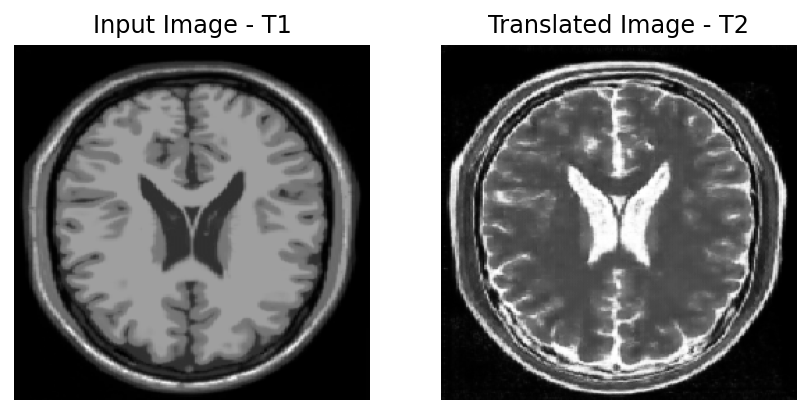

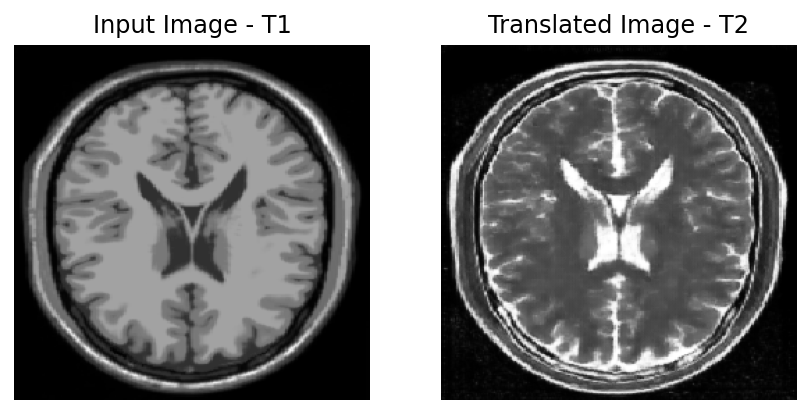

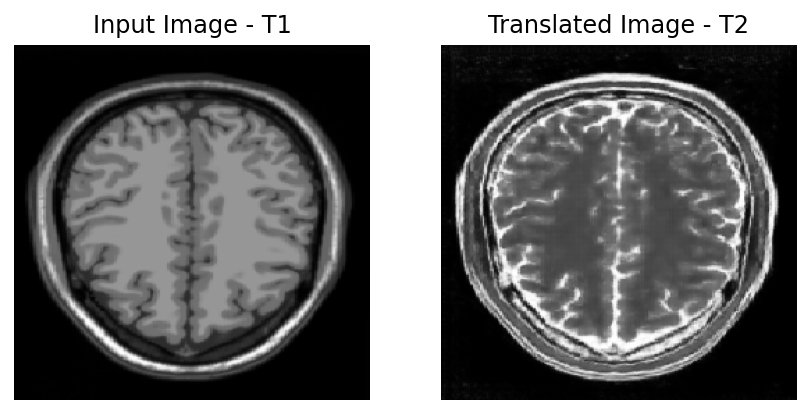

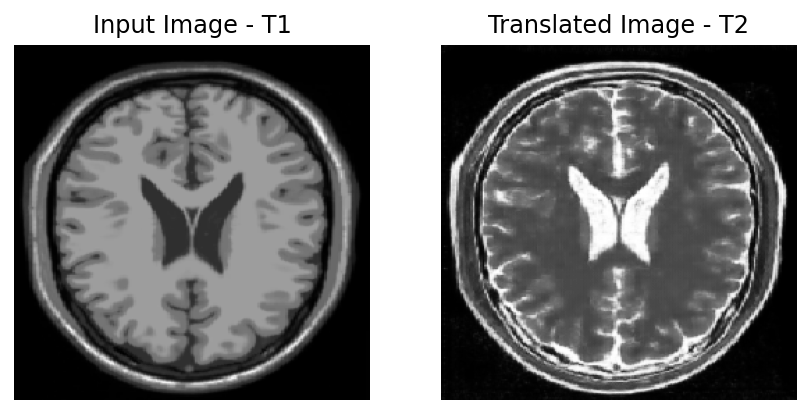

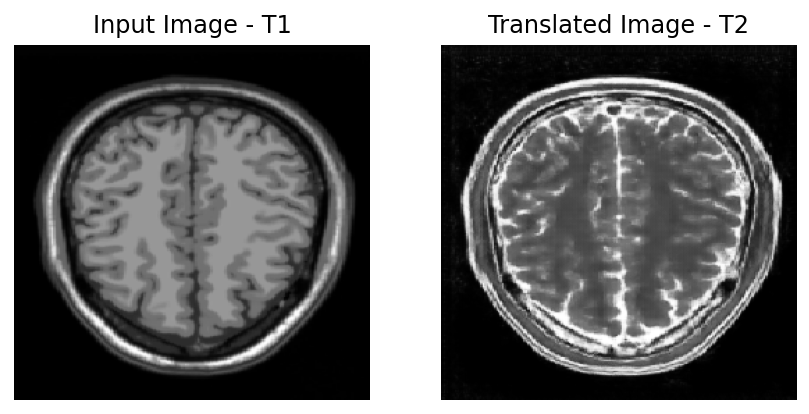

In [35]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
  generate_images_test(generator_g, inp)

**On testing side also we can see that, images from T1 domain decently translated to T2 domain.**

**CycleGAN can be leveraged to synthesize MRI images of any contrast levels! Moreover, it can even potentially be deployed accurately derive CT scans, PET scans, X-rays and etc. from MRI scans and vice versa!**